<a href="https://colab.research.google.com/github/87tana/Image-Segmentation/blob/main/Tumor_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [4]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [5]:
# Path to the JSON file
train_annotations_path = 'Tumor_Segmentation/train/_annotations.coco.json'
valid_annotations_path = 'Tumor_Segmentation/valid/_annotations.coco.json'
test_annotations_path = 'Tumor_Segmentation/test/_annotations.coco.json'

# Path to image directories
train_img_path = 'Tumor_Segmentation/train'
valid_img_path = 'Tumor_Segmentation/valid'
test_img_path = 'Tumor_Segmentation/test'

In [21]:
import os
import json
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cv2
import skimage  # import scikit_image
import tifffile  # for reading and writing TIFF
import shutil #Higher-level interface for file operations, including file copying, removal, and archiving


In [7]:
with open(valid_annotations_path,'r') as file:
   data = json.load(file)


In [8]:
id=1
print(data['images'][id]['file_name'])
print(data['images'][id]['width'])
print(data['images'][id]['height'])
print(data['annotations'][id]['category_id'])
print(data['annotations'][id]['segmentation'][0])



2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg
640
640
1
[380, 326.25, 235, 326.25, 235, 475, 380, 475, 380, 326.25]


In [9]:
len(data['images'])

429

In [ ]:
file_name = []
width = []
height = []
category_id = []
segmenation = []
subset = []


for s in ['train', 'valid', 'test']:
  with open('Tumor_Segmentation/'+s+'/_annotations.coco.json','r') as file:
    data = json.load(file)
    for id in range(len(data['images'])):
      file_name.append(data['images'][id]['file_name'])
      width.append(data['images'][id]['width'])
      height.append(data['images'][id]['height'])
      category_id.append(data['annotations'][id]['category_id'])
      segmenation.append(data['annotations'][id]['segmentation'][0])
      subset.append(s)


dic = {'file_name': file_name, 'width': width , 'height': height,\
        'category_id': category_id, 'segmentation': segmenation, 'subset': subset}



In [ ]:
df = pd.DataFrame.from_dict(dic)
df

,file_name,width,height,category_id,segmentation,subset
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,1,"[313.75, 238.75, 145, 238.75, 145, 401.25, 313...",train
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,1,"[342.5, 176.25, 193.75, 176.25, 193.75, 410, 3...",train
2,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg,640,640,1,"[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295, ...",train
3,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg,640,640,1,"[383.75, 357.5, 245, 357.5, 245, 523.75, 383.7...",train
4,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg,640,640,1,"[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5,...",train
...,...,...,...,...,...,...
2141,2456_jpg.rf.fbc4e1bf546033f504b0adbf5959bb50.jpg,640,640,1,"[407.5, 251.25, 180, 251.25, 180, 452.5, 407.5...",test
2142,1361_jpg.rf.d77d067dfc6aa94df76a98a34bea8ed5.jpg,640,640,2,"[297.5, 275, 202.5, 275, 202.5, 390, 297.5, 39...",test
2143,1058_jpg.rf.f6d6dcde9564c091b30eb6873641ba36.jpg,640,640,2,"[423.75, 276.25, 352.5, 276.25, 352.5, 352.5, ...",test
2144,2817_jpg.rf.eeb513c4ab3414fdda2bbba660318b57.jpg,640,640,1,"[281.25, 386.25, 157.5, 386.25, 157.5, 530, 28...",test


In [14]:
def draw_mask(img_names,data):
    fig,ax = plt.subplots(2,2,figsize =(15,15))

    for i,img_name in enumerate(img_names): # iterates over each image file name in img_names
        img = cv2.imread(img_name)  # for each image, it reads the image using OpenCV
        img_filename = os.path.basename(img_name)  #it extract the file name from the path
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_mask = [mask for mask in data['annotations'] if mask['image_id']==img_id]
        point_list = img_mask[0]['segmentation']
        points = np.array(point_list,np.int32)

        points = points.reshape((-1,1,2))


        cv2.polylines(img,[points],True,(0,0,255),3)

        ax[i//2, i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()

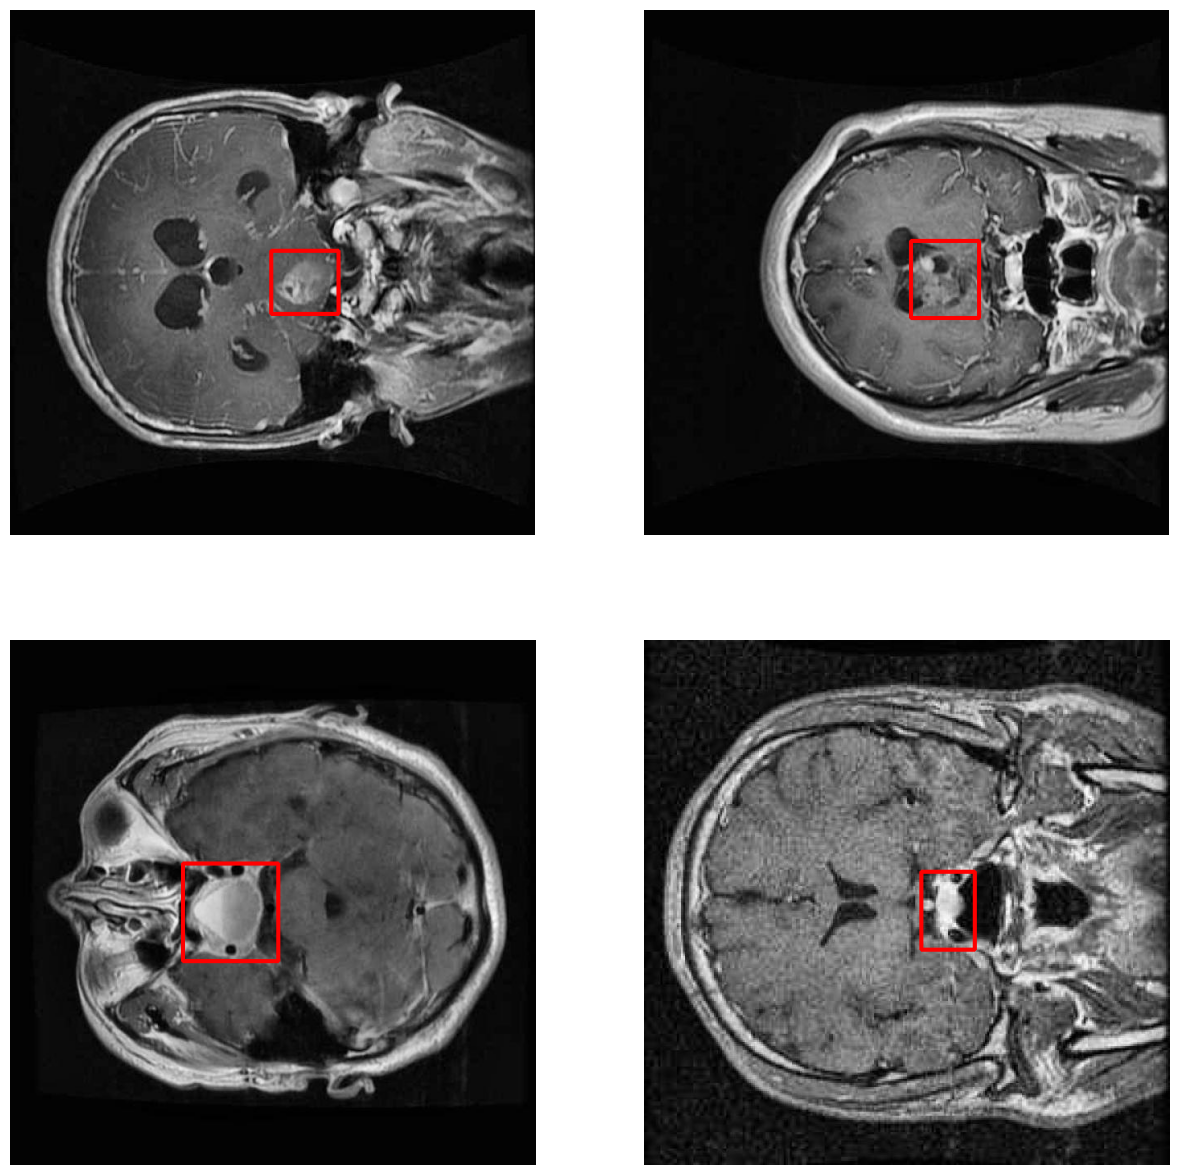

In [15]:
with open(valid_annotations_path,'r') as file:
    data = json.load(file)

img_dir = 'valid_img_path'
all_img_files = [os.path.join(valid_img_path,img['file_name']) for img in data['images']]
random_file = random.sample(all_img_files,4)
draw_mask(random_file,data)

# Convert to mask

In [20]:
def create_mask(image_info,annotations,output_folder,max_print=3):
   mask_np =np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)
   obj_number =1
   printed_masks =0;

   for ann in annotations:
       if image_info['id'] == ann['image_id']:
           for seg_idx ,seg in enumerate(ann['segmentation']):
               rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
               seg_mask = np.zeros_like(mask_np,dtype=np.uint8)
               seg_mask[rr,cc]=255
               mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
               tifffile.imwrite(mask_path, seg_mask)
               printed_masks += 1
               if printed_masks >= max_print:
                   return  # Exit the function if maximum number of masks to print is reached

In [22]:
def main(json_file,mask_output_folder,image_output_folder,original_image_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
     # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)
    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))

        ## learn how to op
        shutil.copy2(original_image_path, new_image_path)

In [ ]:
original_image_dir = 'Tumor_Segmentation/valid'# Where your original images are stored
json_file = 'Tumor_Segmentation/valid/_annotations.coco.json'
image_output_folder = 'valid2/images'  #
main(json_file, image_output_folder, original_image_dir)